In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("CH15-RAG")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH15-RAG


# Summarization 

** 실습 자료 **

소프트웨어정책연구소(SPRi), [AI Brief 스페셜] AI 에이전트 동향

- 저자: 유재흥(AI정책연구실 책임연구원), 이해수(AI정책연구실 선임연구원)
- 발생: 2024.12.10
- 링크: https://spri.kr/posts/view/23798?code=AI-Brief&s_year=&data_page=1
- 파일명: `SPRi AI Brief_Special_AI Agent_241209_F`

(실습 준비)
- 작업 폴더 하위에 `data` 폴더 생성 
- 링크에서 다운로드 받은 파일을 `data` 폴더에 업로드 

** 요약 방법 **

- Stuff : 전체 문서를 한번에 요약  
- Map-reduce : 분할 요약 후 일괄 병합 
- Refine : 분할 요약 후 점진적인 병합 
- Chain of Density : N번 반복 실행 통해 엔티티를 보완하며 요약 개선 
- Clustering Map-refine : 문서 청크를 N개의 클러스터로 나누고, 각 클러스터의 중심점에 가까운 문서를 Refine 요약

## Stuff

- 사전적 의미 : 채우다 
- 문서 목록을 가져와서 모두 프롬프트에 삽입 

In [3]:
from langchain_community.document_loaders import TextLoader
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_teddynote.callbacks import StreamingCallback

In [4]:
loader = TextLoader("data/news.txt")
docs = loader.load()

print(f"총 글자수: {len(docs[0].page_content)}")
print("\n========= 앞부분 미리보기 =========\n")
print(docs[0].page_content[:500])

총 글자수: 1708

========= 앞부분 미리보기 =========

제목: 
AI2, 상업 활용까지 자유로운 '진짜' 오픈 소스 LLM '올모' 출시

내용:
앨런AI연구소(AI2)가 완전한 오픈 소스 대형언어모델(LLM) '올모(OLMo)’를 출시했다. 데이터 수집, 학습, 배포의 전 과정을 투명하게 공개한 데다 상업적 사용까지 허용한 진정한 의미의 오픈 소스 LLM이라는 평가다.
벤처비트는 1일(현지시간) 비영리 민간 AI 연구기관인 AI2가 ‘최초의 진정한 오픈 소스 LLM 및 프레임워크’라고 소개한 ‘올모’를 출시했다고 보도했다. 
이에 따르면 올모는 모델 코드와 모델 가중치뿐만 아니라 훈련 코드, 훈련 데이터, 관련 툴킷 및 평가 툴킷도 제공한다. 이를 통해 모델이 어떻게 구축되었는지 심층적으로 분석, LLM의 작동 방식과 응답을 생성하는 원리를 더 잘 이해할 수 있다. 
올모 프레임워크는 70억 매개변수의 ‘올모 7B’ 등 4가지 변형 모델과 10억 매개변수의 ‘올모 1B’ 모델을 제공한다. 모델들은 훈련 데이터를 생성하는 코드를 포함해 


In [5]:
prompt = hub.pull("teddynote/summary-stuff-documents-korean")
prompt.pretty_print()

Please summarize the sentence according to the following REQUEST.
REQUEST:
1. Summarize the main points in bullet points in KOREAN.
2. Each summarized sentence must start with an emoji that fits the meaning of the each sentence.
3. Use various emojis to make the summary more interesting.
4. Translate the summary into KOREAN if it is written in ENGLISH.
5. DO NOT translate any technical terms.
6. DO NOT include any unnecessary information.

CONTEXT:
{context}

SUMMARY:"



In [6]:
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    streaming=True,
    temperature=0,
    callbacks=[StreamingCallback()],
)

stuff_chain = create_stuff_documents_chain(llm, prompt)
answer = stuff_chain.invoke({"context": docs})

- 🚀 **AI2가 '올모(OLMo)'라는 완전한 오픈 소스 LLM을 출시했다.**  
- 📊 **모델 코드, 가중치, 훈련 데이터 및 도구킷을 모두 공개하여 투명성을 강조했다.**  
- 🛠️ **올모는 70억 매개변수의 '올모 7B'와 10억 매개변수의 '올모 1B' 모델을 포함한 4가지 변형 모델을 제공한다.**  
- 📈 **상업적 활용에 제한이 없으며, 아파치 2.0 라이선스 하에 배포된다.**  
- 🔍 **훈련 데이터에 대한 접근이 가능하여 연구자들이 모델 작동 원리를 이해할 수 있도록 돕는다.**  
- 🌍 **올모는 상업용 제품과 동등한 성능을 보여주지만, 비영어권 언어에 대한 품질이 낮고 코드 생성 기능이 약하다.**  
- 🔄 **AI2는 다양한 모델 크기와 기능을 통해 올모를 지속적으로 개선할 계획이다.**  
- 🌐 **올모의 모든 리소스는 깃허브 및 허깅페이스에서 무료로 제공된다.**  

## Map-Reduce

- 긴 문서를 요약하는 방법 중 하나
- 대규모 문서 처리에 유용하고, 언어 모델의 토큰 제한을 우회할 수 있음 
- map-reduce 
    - map : 문서를 청크 단위로 나누고 
    - reduce : 각 청크의 요약을 결합 

In [7]:
from langchain_community.document_loaders import PyPDFLoader
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_teddynote.messages import stream_response

In [8]:
loader = PyPDFLoader("data/SPRi AI Brief_Special_AI Agent_241209_F.pdf")
docs = loader.load()
docs = docs[3:8]  # 여기서 문서의 일부만 요약

print(f"총 페이지수: {len(docs)}")

총 페이지수: 5


### map

In [9]:
llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o-mini",
)

# map prompt 다운로드
map_prompt = hub.pull("teddynote/map-prompt")

# 프롬프트 출력
map_prompt.pretty_print()

================================ System Message ================================

You are a professional main thesis extractor.

================================ Human Message =================================

Your task is to extract main thesis from given documents. Answer should be in same language as given document. 

#Format: 
- thesis 1
- thesis 2
- thesis 3
- ...

Here is a given document: 
{doc}

Write 1~5 sentences.
#Answer:


In [10]:
# map chain 생성
map_chain = map_prompt | llm | StrOutputParser()

# 문서에 대한 주요내용 추출
doc_summaries = map_chain.batch(docs)

In [11]:
# 요약된 문서의 수 출력
len(doc_summaries)

# 일부 문서의 요약 출력
print(doc_summaries[0])

- AI 에이전트는 사용자 또는 다른 시스템을 대신하여 작업을 자율적으로 수행할 수 있는 시스템으로 정의된다.
- AI 기술의 발전과 클라우드 및 엣지 컴퓨팅의 발전으로 AI 에이전트의 수요가 증가하고 있으며, 다양한 산업에서 활용 가능성이 커지고 있다.
- AI 에이전트는 고객 서비스, 스마트홈, 산업 자동화 등에서 자연스러운 상호작용을 요구하는 환경에서 중요한 역할을 할 것으로 기대된다.
- 시장조사기관 Markets&Markets에 따르면, AI 에이전트 시장은 2024년 51억 달러에서 2030년 471억 달러로 성장할 것으로 예상되며, 연평균 성장률은 44.8%에 이를 것으로 전망된다.
- AI 에이전트는 NLP, 머신러닝, 컴퓨터 비전 등을 포함하여 다양한 업무 자동화와 데이터 분석을 지원하는 소프트웨어로 사용된다.


### reduce

In [12]:
# reduce prompt 다운로드
reduce_prompt = hub.pull("teddynote/reduce-prompt")

# 프롬프트 출력
reduce_prompt.pretty_print()

================================ System Message ================================

You are a professional summarizer. You are given a list of summaries of documents and you are asked to create a single summary of the documents.

================================ Human Message =================================

#Instructions: 
1. Extract main points from a list of summaries of documents
2. Make final summaries in bullet points format.
3. Answer should be written in {language}.

#Format: 
- summary 1
- summary 2
- summary 3
- ...

Here is a list of summaries of documents: 
{doc_summaries}

#SUMMARY:


In [13]:
# reduce chain 생성
reduce_chain = reduce_prompt | llm | StrOutputParser()

# 실행 
answer = reduce_chain.stream(
    {"doc_summaries": "\n".join(doc_summaries), "language": "Korean"}
)
stream_response(answer)

- AI 에이전트는 자율적으로 작업을 수행하는 시스템으로, 다양한 산업에서 활용 가능성이 증가하고 있다.
- AI 기술과 클라우드, 엣지 컴퓨팅의 발전으로 AI 에이전트의 수요가 높아지고 있으며, 고객 서비스, 스마트홈, 산업 자동화 등에서 중요한 역할을 할 것으로 기대된다.
- AI 에이전트 시장은 2024년 51억 달러에서 2030년 471억 달러로 성장할 것으로 예상되며, 연평균 성장률은 44.8%에 이를 전망이다.
- 주요 성장 동인은 개인화된 상호작용에 대한 소비자 기대와 데이터 활용을 통한 맞춤형 추천 및 고객 지원이다.
- 북미 지역이 AI 에이전트 시장에서 40% 이상의 매출 점유율을 차지하고 있으며, 의료 산업이 가장 높은 성장률을 보일 것으로 예상된다.
- Microsoft는 Azure 플랫폼을 통해 AI 에이전트를 개발하고 있으며, 다양한 기업용 서비스와 AI 챗봇 구축 도구를 제공하고 있다.
- Google은 Google Assistant와 Dialogflow 등을 통해 사용자 경험을 극대화하고 있으며, 'Vertex AI Agent Builder'와 'Project Astra'를 통해 보편적인 AI 에이전트를 개발 중이다.

### @tool

In [14]:
from langchain_core.runnables import chain


@chain
def map_reduce_chain(docs):
    map_llm = ChatOpenAI(
        temperature=0,
        model_name="gpt-4o-mini",
    )

    # map prompt 다운로드
    map_prompt = hub.pull("teddynote/map-prompt")

    # map chain 생성
    map_chain = map_prompt | map_llm | StrOutputParser()

    # 첫 번째 프롬프트, ChatOpenAI, 문자열 출력 파서를 연결하여 체인 생성
    doc_summaries = map_chain.batch(docs)

    # reduce prompt 다운로드
    reduce_prompt = hub.pull("teddynote/reduce-prompt")
    reduce_llm = ChatOpenAI(
        model_name="gpt-4o",
        temperature=0,
        callbacks=[StreamingCallback()],
        streaming=True,
    )

    # reduce chain 생성
    reduce_chain = reduce_prompt | reduce_llm | StrOutputParser()

    return reduce_chain.invoke(
        {"doc_summaries": "\n".join(doc_summaries), "language": "Korean"}
    )

In [15]:
# 결과 출력
answer = map_reduce_chain.invoke(docs)

- AI 에이전트는 자율적으로 사용자의 작업을 수행하며, AI 기술의 발전과 함께 다양한 분야에서 수요가 증가하고 있다.
- 클라우드 및 엣지 컴퓨팅의 발전은 AI 에이전트의 실시간 데이터 처리와 빠른 의사결정을 가능하게 한다.
- AI 에이전트 시장은 2024년 51억 달러에서 2030년 471억 달러로 성장할 것으로 예상되며, 연평균 성장률은 약 44.8%에 이를 것으로 전망된다.
- AI 에이전트는 NLP, 머신러닝, 컴퓨터 비전 등을 활용하여 업무 자동화와 데이터 분석을 지원한다.
- 북미 지역이 AI 에이전트 시장을 주도하고 있으며, 주요 기술 회사들이 기술 개발을 선도하고 있다.
- 의료 산업은 AI 에이전트의 높은 성장률을 보일 것으로 예상되며, 환자 참여 개선과 운영 효율성이 성장을 주도할 것이다.
- Microsoft는 Azure를 중심으로 AI 에이전트를 개발하고 있으며, OpenAI와의 파트너십을 통해 다양한 상용화 제품을 출시하고 있다.
- Microsoft의 AI 제품군은 기업용 서비스, 사무 자동화, 개발자 지원 도구 등 다양한 분야에서 활용되고 있다.
- Google은 Google Assistant, Dialogflow, Duplex 등을 통해 사용자 경험을 극대화하고 있으며, 'Vertex AI Agent Builder'를 제공하고 있다.
- Google의 'Project Astra'는 Gemini 모델을 기반으로 다중모드 정보를 처리하는 AI 어시스턴트를 개발하고 있다.
- Google Assistant는 음성 및 텍스트 대화를 통해 다양한 일상 업무를 지원하며, 여러 디바이스에서 사용 가능하다.

## Map-Refine

- 단계 
    - map 단계 : 문서를 청크 단위로 나누고, 각 청크에 대해 개별적으로 요약 생성 
    - refine 단계 
        - 생성된 요약들을 순차적으로 처리하여 최종 요약을 점진적으로 개선 
        - 각 단계에서 이전 요약과 새로운 청크의 정보를 결합하여 요약 갱신 
        - 문서 순서는 유지 
    - 반복 과정 : 모든 청크가 처리될 때까지 refine 단계 반복 수행 
    - 최종 요약 : 마지막 청크까지 처리한 결과 
- 장점 
    - 문서의 순서를 유지하면서 점진적으로 요약 개선 
    - 문서의 맥락이 중요한 경우 유용
- 단점 
    - 순차적으로 처리되기 때문에 병렬화 어려움 
    - 대규모 문서에서는 부담이 될 수 있음 

In [16]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

### map

In [17]:
# map llm 생성
map_llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o-mini",
)

# map chain 생성
map_summary = hub.pull("teddynote/map-summary-prompt")

# 프롬프트 출력
map_summary.pretty_print()

================================ System Message ================================

You are an expert summarizer. Your task is to summarize the following document in {language}.

================================ Human Message =================================

Extract most important main thesis from the documents, then summarize in bullet points.

#Format:
- summary 1
- summary 2
- summary 3
-...

Here is a given document: 
{documents}

Write 1~5 sentences. Think step by step.
#Summary:


In [18]:
# map chain 생성
map_chain = map_summary | llm | StrOutputParser()

print(map_chain.invoke({"documents": docs[0], "language": "Korean"}))

- AI 에이전트는 사용자의 작업을 자율적으로 수행할 수 있는 시스템으로, 클라우드 및 엣지 컴퓨팅의 발전으로 실시간 데이터 처리와 빠른 의사결정이 가능해졌다.
- AI 기술의 발전, 특히 강화 학습, 자연어 처리, 컴퓨터 비전 등의 분야에서 AI 에이전트의 정교한 의사결정과 유연한 대응이 가능해졌다.
- 고객 서비스, 스마트홈, 산업 자동화 등 다양한 분야에서 AI 에이전트의 수요가 증가하고 있으며, 이는 새로운 시장 기회를 창출하고 있다.
- Markets&Markets에 따르면, AI 에이전트 시장은 2024년 51억 달러에서 2030년 471억 달러로 성장할 것으로 예상되며, 연평균 성장률은 44.8%에 이를 것으로 전망된다.
- AI 에이전트는 NLP, 머신러닝, 컴퓨터 비전 등을 활용하여 다양한 업무 자동화와 데이터 분석을 지원하는 소프트웨어로 사용된다.


In [19]:
input_doc = [{"documents": doc, "language": "Korean"} for doc in docs]

In [20]:
# 모든 문서에 대한 요약본을 출력합니다.
print(map_chain.batch(input_doc))

['- AI 에이전트는 사용자의 작업을 자율적으로 수행할 수 있는 시스템으로, 클라우드 및 엣지 컴퓨팅의 발전으로 실시간 데이터 처리와 빠른 의사결정이 가능해졌다.\n- AI 기술의 발전, 특히 강화 학습, 자연어 처리, 컴퓨터 비전 등의 분야에서 AI 에이전트의 정교한 의사결정과 유연한 대응이 가능해졌다.\n- 고객 서비스, 스마트홈, 산업 자동화 등 다양한 분야에서 AI 에이전트의 수요가 증가하고 있으며, 이는 새로운 시장 기회를 창출하고 있다.\n- Markets&Markets에 따르면, AI 에이전트 시장은 2024년 51억 달러에서 2030년 471억 달러로 성장할 것으로 예상되며, 연평균 성장률은 44.8%에 이를 것으로 전망된다.\n- AI 에이전트는 NLP, 머신러닝, 컴퓨터 비전 등을 활용하여 다양한 업무 자동화와 데이터 분석을 지원하는 소프트웨어로 사용된다.', '- 2023년 글로벌 AI 에이전트 시장 규모는 38억 6천만 달러로 추정되며, 2024년부터 2030년까지 연평균 성장률(CAGR) 45.1%로 성장할 것으로 예상됨.\n- 소비자 기대에 따른 개인화된 상호작용, 데이터 활용을 통한 맞춤형 추천 및 고객 지원이 AI 에이전트 시장 성장의 주요 동인으로 작용함.\n- 북미 지역이 AI 에이전트 시장에서 2023년 40% 이상의 매출 점유율을 기록하며, 의료 산업이 가장 높은 성장률을 보일 것으로 전망됨.\n- 주요 기술 회사들이 AI 에이전트 기술 개발을 선도하고 있으며, 스타트업 생태계가 다양한 산업에서 AI 에이전트 발전을 촉진하고 있음.\n- 의료 부문은 환자 참여 개선 및 운영 효율성 향상 등으로 인해 2030년까지 가장 높은 성장률을 기록할 것으로 예상됨.', "- Microsoft는 Azure 클라우드 플랫폼을 중심으로 강력한 AI 에이전트를 개발하고 있으며, OpenAI와의 파트너십을 통해 ChatGPT와 기타 AI 모델을 통합하여 다양한 상용화 제품을 출시하고 있다.\n- Microsoft의 제품군은 기업용 서비스, 사

### refine

In [21]:
# refine prompt 다운로드
refine_prompt = hub.pull("teddynote/refine-prompt")

# 프롬프트 출력
refine_prompt.pretty_print()

================================ System Message ================================

You are an expert summarizer.

================================ Human Message =================================

Your job is to produce a final summary

We have provided an existing summary up to a certain point:
{previous_summary}

We have the opportunity to refine the existing summary(only if needed) with some more context below.
------------
{current_summary}
------------
Given the new context, refine the original summary in {language}.
If the context isn't useful, return the original summary.


In [22]:
# refine llm 생성
refine_llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o-mini",
)

# refine chain 생성
refine_chain = refine_prompt | refine_llm | StrOutputParser()

### @tool

In [23]:
from langchain_core.runnables import chain


@chain
def map_refine_chain(docs):

    # map chain 생성
    map_summary = hub.pull("teddynote/map-summary-prompt")

    map_chain = (
        map_summary
        | ChatOpenAI(
            model_name="gpt-4o-mini",
            temperature=0,
        )
        | StrOutputParser()
    )

    input_doc = [{"documents": doc.page_content, "language": "Korean"} for doc in docs]

    doc_summaries = map_chain.batch(input_doc)

    refine_prompt = hub.pull("teddynote/refine-prompt")

    refine_llm = ChatOpenAI(
        model_name="gpt-4o-mini",
        temperature=0,
        callbacks=[StreamingCallback()],
        streaming=True,
    )

    refine_chain = refine_prompt | refine_llm | StrOutputParser()

    previous_summary = doc_summaries[0]

    for current_summary in doc_summaries[1:]:

        previous_summary = refine_chain.invoke(
            {
                "previous_summary": previous_summary,
                "current_summary": current_summary,
                "language": "Korean",
            }
        )
        print("\n\n-----------------\n\n")

    return previous_summary

In [24]:
refined_summary = map_refine_chain.invoke(docs)

- AI 에이전트는 사용자의 작업을 자율적으로 수행할 수 있는 시스템으로, 클라우드 및 엣지 컴퓨팅의 발전으로 실시간 데이터 처리와 빠른 의사결정이 가능해졌다.
- AI 기술의 발전, 특히 강화 학습, 자연어 처리, 컴퓨터 비전 등의 분야에서 AI 에이전트의 정교한 의사결정과 유연한 대응이 가능해졌다.
- 고객 서비스, 스마트홈, 산업 자동화 등 다양한 분야에서 AI 에이전트의 수요가 증가하고 있으며, 이는 새로운 시장 기회를 창출하고 있다.
- 2023년 글로벌 AI 에이전트 시장 규모는 38억 6천만 달러로 추정되며, 2024년부터 2030년까지 연평균 성장률(CAGR) 45.1%로 성장할 것으로 예상된다. Markets&Markets에 따르면, AI 에이전트 시장은 2024년 51억 달러에서 2030년 471억 달러로 성장할 것으로 전망되며, 연평균 성장률은 44.8%에 이를 것으로 보인다.
- 소비자 기대에 따른 개인화된 상호작용, 데이터 활용을 통한 맞춤형 추천 및 고객 지원이 AI 에이전트 시장 성장의 주요 동인으로 작용하고 있다.
- 북미 지역이 AI 에이전트 시장에서 2023년 40% 이상의 매출 점유율을 차지하며, 의료 산업이 가장 높은 성장률을 보일 것으로 분석된다.
- 주요 기술 회사들이 AI 에이전트 기술 개발을 선도하고 있으며, 스타트업 생태계가 다양한 산업에서 AI 에이전트 발전을 촉진하고 있다.
- AI 에이전트는 NLP, 머신러닝, 컴퓨터 비전 등을 활용하여 다양한 업무 자동화와 데이터 분석을 지원하는 소프트웨어로 사용된다.

-----------------


- AI 에이전트는 사용자의 작업을 자율적으로 수행할 수 있는 시스템으로, 클라우드 및 엣지 컴퓨팅의 발전으로 실시간 데이터 처리와 빠른 의사결정이 가능해졌다.
- AI 기술의 발전, 특히 강화 학습, 자연어 처리, 컴퓨터 비전 등의 분야에서 AI 에이전트의 정교한 의사결정과 유연한 대응이 가능해졌다.
- 고객 서비스, 스마트홈, 산업 자동화 등 다양한 분야에서 AI 에이전

## Chain-of-Density

- 초기에 엔티티가 적은 요약을 생성한 후, 
- 길이를 늘리지 않으면서 누락된 중요 엔티티들을 반복적으로 통합하는 과정
- 일반 프롬프트 통한 요약 보다 정보 밀도가 높은 편 

In [25]:
import textwrap
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import SimpleJsonOutputParser

In [26]:
# Chain of Density 프롬프트 다운로드
cod_prompt = hub.pull("teddynote/chain-of-density-prompt")

cod_prompt.pretty_print()

================================ System Message ================================

As an expert copy-writer, you will write increasingly concise, entity-dense summaries of the user provided {content_category}. The initial summary should be under {max_words} words and contain {entity_range} informative Descriptive Entities from the {content_category}.

A Descriptive Entity is:
- Relevant: to the main story.
- Specific: descriptive yet concise (5 words or fewer).
- Faithful: present in the {content_category}.
- Anywhere: located anywhere in the {content_category}.

# Your Summarization Process
- Read through the {content_category} and the all the below sections to get an understanding of the task.
- Pick {entity_range} informative Descriptive Entities from the {content_category} (";" delimited, do not add spaces).
- In your output JSON list of dictionaries, write an initial summary of max {max_words} words containing the Entities.
- You now have `[{"missing_entities": "...", "denser_summa

In [27]:
# {content}를 제외한 모든 입력에 대한 기본값 지정
# content : 요약 대상
# entity_range : 앞선 요약에서 빠진 엔티티에서 찾아야 할 개수
# iterations : 논문에서 5번 정도 하면 사람이 하는 수준 보다 높다. 라는 벤치마크. 값이 크면 비용이 많이 발생
cod_chain_inputs = {
    "content": lambda d: d.get("content"),
    "content_category": lambda d: d.get("content_category", "Article"),
    "entity_range": lambda d: d.get("entity_range", "1-3"),
    "max_words": lambda d: int(d.get("max_words", 80)),
    "iterations": lambda d: int(d.get("iterations", 5)),
}

# Chain of Density 프롬프트 다운로드
cod_prompt = hub.pull("teddynote/chain-of-density-prompt")

# Chain of Density 체인 생성
cod_chain = (
    cod_chain_inputs
    | cod_prompt
    | ChatOpenAI(temperature=0, model="gpt-4o-mini")
    | SimpleJsonOutputParser()
)

# 두 번째 체인 생성, 최종 요약만 추출 (스트리밍 불가능, 최종 결과가 필요함)
cod_final_summary_chain = cod_chain | (
    lambda output: output[-1].get(
        "denser_summary", '오류: 마지막 딕셔너리에 "denser_summary" 키가 없습니다'
    )
)

In [28]:
content = docs[3].page_content
print(content)

SPRi AI Brief Special |  2024-12 월호
6£(수익 모델) Microsoft 는 AI 관련 제품군 을 구독 모델로 제공하며 , 기업과 개인 사용자가 
Azure 클라우드를 통해 AI 기능을 필요에 따라 활용할 수 있도록 지원
∙Microsoft 는 OpenAI 의 모델을 Azure 클라우드에서 제공하며 , 기업 고객은 이 API를 구독하여 모델을 활용 가능
∙Office 365에 통합된 Copilot 기능은 상용화된 서비스로 , 기업 고객과 개인 사용자가 Copilot 의 생산성 
향상 기능을 사용하기 위해 추가 요금 지불
∙Power Virtual Agents 를 포함한 Power Platform 은 구독 모델로 제공되며 , 사용자는 다양한 비즈니스 
응용 프로그램에서 AI 기능을 활용 가능
£(최신 동정) Microsoft 는 새로운 단계의 Microsoft 365 Copilot 혁신 서비스들을 발표
∙2024년 9월 Microsoft 는 새로운 단계의 Microsoft 365 Copilot 혁신 서비스들을 발표하면서 , 
Microsoft Copilot Studio 로 구축되어 비즈니스를 혁신할 수 있는 Copilot 에이전트를 소개13)
※ Copilot 에이전트들은 이메일 보내기 , 레코드 업데이트 또는 지원 티켓 만들기와 같은 새로운 기술을 에이전트에게 제공하여 
에이전트의 기능을 확장할 수도 있음 
∙2024년 11월 20일, Microsoft 는 ‘Microsoft Ignite 2024’ 행사에서 AI 에이전트 시대를 열겠다고 
밝히면서 AI 기반 작업 도우미인 마이크로소프트 365 Copilot 의 신규 AI 에이전트와 기능, 자율 
에이전트 (autonomous agents) 등을 대거 선보임14) 
※ ‘Microsoft Ignite 2024’ 행사에서 선보인 AI 에이전트 : 금융통찰력 에이전트 (Financial Insights Agent), 공장운영 
에이전트 (Factory Operations Agent), 공

In [29]:
# 결과를 저장할 빈 리스트 초기화
results: list[dict[str, str]] = []

# cod_chain을 스트리밍 모드로 실행하고 부분적인 JSON 결과를 처리
for partial_json in cod_chain.stream(
    {"content": content, "content_category": "Article"}
):
    # 각 반복마다 results를 업데이트
    results = partial_json

    # 현재 결과를 같은 줄에 출력 (캐리지 리턴을 사용하여 이전 출력을 덮어씀)
    print(results, end="\r", flush=True)

# 총 요약 수 계산
total_summaries = len(results)
print("\n")

# 각 요약을 순회하며 처리
i = 1
for cod in results:
    # 누락된 엔티티들을 추출하고 포맷팅
    added_entities = ", ".join(
        [
            ent.strip()
            for ent in cod.get(
                "missing_entities", 'ERR: "missing_entiies" key not found'
            ).split(";")
        ]
    )
    # 더 밀도 있는 요약 추출
    summary = cod.get("denser_summary", 'ERR: missing key "denser_summary"')

    # 요약 정보 출력 (번호, 총 개수, 추가된 엔티티)
    print(
        f"### CoD Summary {i}/{total_summaries}, 추가된 엔티티(entity): {added_entities}"
        + "\n"
    )
    # 요약 내용을 80자 너비로 줄바꿈하여 출력
    print(textwrap.fill(summary, width=80) + "\n")
    i += 1

print("\n============== [최종 요약] =================\n")
print(summary)

[{'missing_entities': 'Microsoft;AI 에이전트;Google', 'denser_summary': "This Article discusses Microsoft and Google, focusing on their AI offerings. Microsoft provides AI products via subscription models, including Azure cloud services and Office 365's Copilot. New AI agents were introduced at Microsoft Ignite 2024, enhancing productivity. Google maximizes user experience through Google Assistant and Dialogflow, while developing universal AI agents via Project Astra."}, {'missing_entities': 'Copilot;Azure 클라우드;Dialogflow', 'denser_summary': 'Microsoft and Google lead in AI, with Microsoft offering subscription-based AI products like Azure cloud services and Copilot for productivity. New AI agents were showcased at Microsoft Ignite 2024. Google enhances user experience through Google Assistant and Dialogflow, while developing universal AI agents via Project Astra.'}, {'missing_entities': 'Power Platform;Microsoft Ignite 2024;Vertex AI Agent Builder', 'denser_summary': 'Microsoft and Google

## Clustering-Map-Refine

- 문서를 N개의 클러스터로 나눈 후 
- 가장 중심축에서 가까운 문서를 클러스터의 대표 문서로 인지하고 
- 이를 map-reduce (or map-refine) 방식으로 요약하는 방식 

In [30]:
from langchain_core.documents import Document
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from sklearn.cluster import KMeans

In [31]:
loader = PyMuPDFLoader("data/SPRi AI Brief_Special_AI Agent_241209_F.pdf")
docs = loader.load()

len(docs)

27

In [32]:
# 하나의 Text 로 모든 문서 연결
texts = "\n\n".join([doc.page_content for doc in docs])

len(texts)

33408

In [33]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
split_docs = text_splitter.split_text(texts)

len(split_docs)

91

In [34]:
embeddings = OpenAIEmbeddings()
vectors = embeddings.embed_documents(split_docs)

print(len(vectors), len(vectors[0]))

91 1536


### clustering

총 91개의 문서를 10개 클러스터로 나눔 

In [35]:
# 클러스터 수를 선택하면 문서의 콘텐츠에 따라 조정
num_clusters = 10

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=123).fit(vectors)

In [36]:
# 라벨링 된 결과 확인
kmeans.labels_

array([6, 3, 1, 1, 3, 1, 1, 3, 1, 1, 0, 3, 1, 1, 4, 4, 4, 4, 4, 1, 1, 4,
       3, 1, 1, 3, 1, 1, 0, 7, 7, 7, 7, 7, 7, 7, 6, 2, 2, 2, 2, 2, 2, 2,
       8, 8, 8, 8, 9, 9, 3, 8, 5, 5, 5, 5, 5, 5, 5, 5, 3, 1, 0, 0, 0, 0,
       0, 3, 3, 3, 1, 1, 1, 9, 3, 1, 1, 1, 3, 6, 9, 9, 0, 0, 6, 4, 0, 5,
       5, 0, 3], dtype=int32)

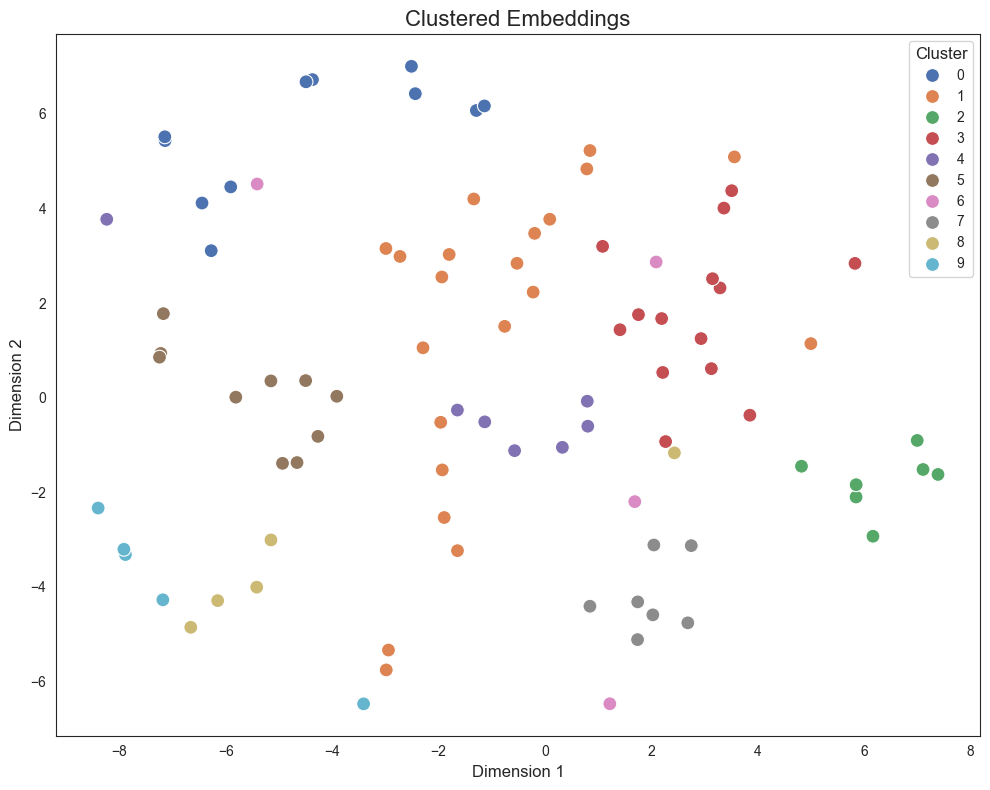

In [37]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 경고 제거
import warnings

warnings.filterwarnings("ignore")

# t-SNE 수행 및 2차원으로 축소
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(np.array(vectors))

# seaborn 스타일 설정
sns.set_style("white")

# 축소된 데이터 플롯
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=reduced_data_tsne[:, 0],
    y=reduced_data_tsne[:, 1],
    hue=kmeans.labels_,
    palette="deep",
    s=100,
)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.title("Clustered Embeddings", fontsize=16)
plt.legend(title="Cluster", title_fontsize=12)

# 배경색 설정
plt.gcf().patch.set_facecolor("white")

plt.tight_layout()
plt.show()

In [38]:
import numpy as np

# 가장 가까운 점들을 저장할 빈 리스트 생성
closest_indices = []

# 클러스터 수만큼 반복
for i in range(num_clusters):

    # 해당 클러스터 중심으로부터의 거리 목록 구하기
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)

    # 가장 가까운 점의 인덱스 찾기 (argmin을 사용하여 최소 거리 찾기)
    closest_index = np.argmin(distances)

    # 해당 인덱스를 가장 가까운 인덱스 리스트에 추가
    closest_indices.append(closest_index)

In [39]:
closest_indices

[86, 76, 39, 78, 15, 57, 79, 34, 44, 49]

In [40]:
# 문서의 요약을 순서대로 진행하기 위하여 오름차순 정렬
selected_indices = sorted(closest_indices)
selected_indices

[15, 34, 39, 44, 49, 57, 76, 78, 79, 86]

In [41]:
selected_docs = [Document(page_content=split_docs[doc]) for doc in selected_indices]
selected_docs

[Document(page_content='<Microsoft 제품군>  \n*출처: microsoft.com\n£ (기능/기술) Microsoft의 제품군은 다양한 플랫폼과 통합되어, 기업들이 AI 에이전트를 \n활용해 업무 협업, 고객 응대 자동화, 챗봇 구축 등을 쉽게 수행 지원\n∙‘Copilot Studio’는 Microsoft의 다양한 플랫폼(예: Office 365, Teams, Power Platform)과 통합되어 \n있어, 기업의 업무 환경에서 사용자가 생성한 AI 에이전트와 협업할 수 있도록 지원\n∙Microsoft의 ‘Azure OpenAI Service’는 OpenAI의 GPT 모델을 자사의 클라우드 플랫폼인 Azure를 \n통해 제공하여 사용자들은 대화형 응답, 자동화된 고객 서비스, 정보 요약 등 여러 작업을 수행 가능11)\n∙Microsoft의 ‘Power Virtual Agents’로 기업 고객은 코딩 없이 인터페이스를 AI 챗봇으로 쉽게 구축 가능 12)'),
 Document(page_content='부가 가치를 높이는 기능으로 작용하여 기기 판매와 Apple 생태계에 대한 사용자 충성도를 강화하는 데 기여 \n∙Apple의 고객 중심 개인정보 보호 전략에 따라 Siri는 사용자 데이터 수집을 최소화하며, Google이나 \nAmazon과 달리 광고 모델을 통해 수익 창출을 하지 않음\n£ (최신 동정) 2024년 6월 Apple은 세계개발자대회(WWDC)에서 iPhone, iPad, Mac의 핵심 \n기능으로 강력한 생성 모델을 적용한 개인 인텔리전스 시스템인 Apple Intelligence를 소개21)\n∙생성형 모델의 힘과 개인 맥락을 결합하여 사용자에게 유용하고 관련성 있는 인텔리전스를 제공 \n∙2024년 10월 28일, Apple은 Apple Intelligence를 공식 출시하였고, 사용자들은 이를 활용하여 \n글쓰기를 다듬고, 알림, 메일, 메시지를 요약하고, 보다 자연스럽고 강력한 Siri를 경험하고, C

### map-refine

In [42]:
# 이전에 생성한 map_refine_chain을 사용하여 요약 생성
refined_summary = map_refine_chain.invoke(selected_docs)

- Microsoft의 제품군은 AI 에이전트를 활용하여 기업의 업무 협업과 고객 응대 자동화를 지원한다.
- 'Copilot Studio'는 Office 365, Teams, Power Platform 등과 통합되어 사용자가 생성한 AI 에이전트와 협업할 수 있게 한다.
- 'Azure OpenAI Service'는 OpenAI의 GPT 모델을 Azure 클라우드 플랫폼을 통해 제공하여 다양한 작업을 수행할 수 있도록 한다.
- 'Power Virtual Agents'를 통해 기업 고객은 코딩 없이 AI 챗봇을 쉽게 구축할 수 있다.
- Apple은 기기 판매와 생태계에 대한 사용자 충성도를 높이기 위해 부가 가치를 강화하는 기능을 제공하며, Siri는 고객 중심의 개인정보 보호 전략에 따라 사용자 데이터 수집을 최소화한다.
- 2024년 6월, Apple은 개인 인텔리전스 시스템인 Apple Intelligence를 소개하였고, 2024년 10월 28일에 공식 출시되어 사용자들은 글쓰기, 알림, 메일, 메시지 요약 등 다양한 기능을 활용할 수 있다.

-----------------


- Microsoft의 제품군은 AI 에이전트를 활용하여 기업의 업무 협업과 고객 응대 자동화를 지원한다.
- 'Copilot Studio'는 Office 365, Teams, Power Platform 등과 통합되어 사용자가 생성한 AI 에이전트와 협업할 수 있게 한다.
- 'Azure OpenAI Service'는 OpenAI의 GPT 모델을 Azure 클라우드 플랫폼을 통해 제공하여 다양한 작업을 수행할 수 있도록 한다.
- 'Power Virtual Agents'를 통해 기업 고객은 코딩 없이 AI 챗봇을 쉽게 구축할 수 있다.
- Apple은 기기 판매와 생태계에 대한 사용자 충성도를 높이기 위해 부가 가치를 강화하는 기능을 제공하며, Siri는 고객 중심의 개인정보 보호 전략에 따라 사용자 데이터 수집을 최소화한다.
- 2024년 6월, Apple은 개인 인텔리전

In [43]:
# 최종 결과 출력
print(refined_summary)

- Microsoft의 제품군은 AI 에이전트를 활용하여 기업의 업무 협업과 고객 응대 자동화를 지원한다.
- 'Copilot Studio'는 Office 365, Teams, Power Platform 등과 통합되어 사용자가 생성한 AI 에이전트와 협업할 수 있게 한다.
- 'Azure OpenAI Service'는 OpenAI의 GPT 모델을 Azure 클라우드 플랫폼을 통해 제공하여 다양한 작업을 수행할 수 있도록 한다.
- 'Power Virtual Agents'를 통해 기업 고객은 코딩 없이 AI 챗봇을 쉽게 구축할 수 있다.
- Apple은 기기 판매와 생태계에 대한 사용자 충성도를 높이기 위해 부가 가치를 강화하는 기능을 제공하며, Siri는 고객 중심의 개인정보 보호 전략에 따라 사용자 데이터 수집을 최소화한다.
- 2024년 6월, Apple은 개인 인텔리전스 시스템인 Apple Intelligence를 소개하였고, 이는 iPhone, iPad, Mac에서 사용 가능하며 강력한 생성 모델을 중심으로 설계되어 사용자에게 개인화된 경험을 제공한다. Apple Intelligence는 2024년 10월 28일에 공식 출시되어 글쓰기, 알림, 메일, 메시지 요약 등 다양한 기능을 활용할 수 있다.
- 메타는 Messenger에 AI 챗봇을 도입하여 고객 서비스와 마케팅 메시지 자동화를 지원하며, AI 언어 모델은 사용자 의도를 이해하고 대화의 일관성을 유지하는 기능을 갖추고 있다.
- Facebook과 Instagram에서는 머신러닝 기반 추천 엔진을 통해 사용자 맞춤형 콘텐츠를 제공하여 참여도를 높이고, 추천 엔진은 사용자의 관심사와 상호작용 패턴을 분석하여 게시물, 광고, 친구 추천 등을 큐레이션한다.
- Horizon Worlds에서는 VR/AR 기반 AI 아바타를 통해 메타버스 내 상호작용을 강화하고 있다.
- AWS는 Amazon의 클라우드 서비스 플랫폼으로, 다양한 산업에 걸쳐 AI 기술을 활용하여 고객 서비스, 보안, 데이터 분석 등을 지

-----
** End of Documents **